# Analyse ERA5 demand for NEM

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
from xhistogram.xarray import histogram

import matplotlib.pyplot as plt

In [2]:
%cd /g/data/w42/dr6273/work/demand_model/

import functions as fn

/g/data/w42/dr6273/work/demand_model


In [3]:
%load_ext autoreload
%autoreload 2

### Set global variables

In [9]:
RESULTS_PATH = "/g/data/w42/dr6273/work/projects/Aus_energy/model_results/"

In [10]:
MARKET = "NEM" # "NEM" or "EU"

In [11]:
REMOVE_WEEKEND = True

In [12]:
REMOVE_XMAS = True

In [13]:
REMOVE_MONTH = 0 # integer: [1, 12]

In [14]:
MASK_NAME = "pop_dens_mask"

In [15]:
TIME_COLUMNS = []

In [16]:
FIRST_TRAIN_YEAR = 2010
LAST_TRAIN_YEAR = 2019

In [17]:
FIRST_TEST_YEAR = 1959
LAST_TEST_YEAR = 2022

In [18]:
N_FEATURES = "parsimonious"

In [19]:
DETREND = False

In [20]:
regions = ["NEM", "QLD", "NSW", "VIC", "SA", "TAS"]

### Load demand and climate data

In [21]:
predictions = fn.read_results(
    "extrapolated", MARKET, regions, MASK_NAME,
    FIRST_TRAIN_YEAR, LAST_TRAIN_YEAR, FIRST_TEST_YEAR, LAST_TEST_YEAR,
    REMOVE_WEEKEND, REMOVE_XMAS, REMOVE_MONTH, N_FEATURES, RESULTS_PATH,
    DETREND
)

In [22]:
pred_ds = {}
for r in regions:
    ds = xr.Dataset.from_dataframe(predictions[r])
    ds = ds.rename({"index": "time", "prediction": "demand"})
    ds = ds.assign_coords({"time": pd.to_datetime(ds["time"])})
    pred_ds[r] = ds

### Compare statistics of train (2010-2019) vs test (1959-2009)

In [24]:
def get_hist(da):
    """
    Compute bins and histogram of da
    """
    dmin = da.min().values
    dmax = da.max().values
    
    bins = np.linspace(
        fn.rounddown(dmin, 10),
        fn.roundup(dmax, 10),
        60
    )
    return histogram(da, bins=[bins], density=True)

In [25]:
def plot_hist(ax, histograms, labels, xlabel, colors=["tab:blue", "tab:orange"]):
    """
    Plot histograms
    """
    for hist, label, color in zip(histograms, labels, colors):
        hist.plot(ax=ax, color=color, label=label)
    ax.set_ylabel("Density [-]")
    ax.set_xlabel(xlabel)

In [26]:
first_vars = [predictions[r].columns[0] for r in regions]

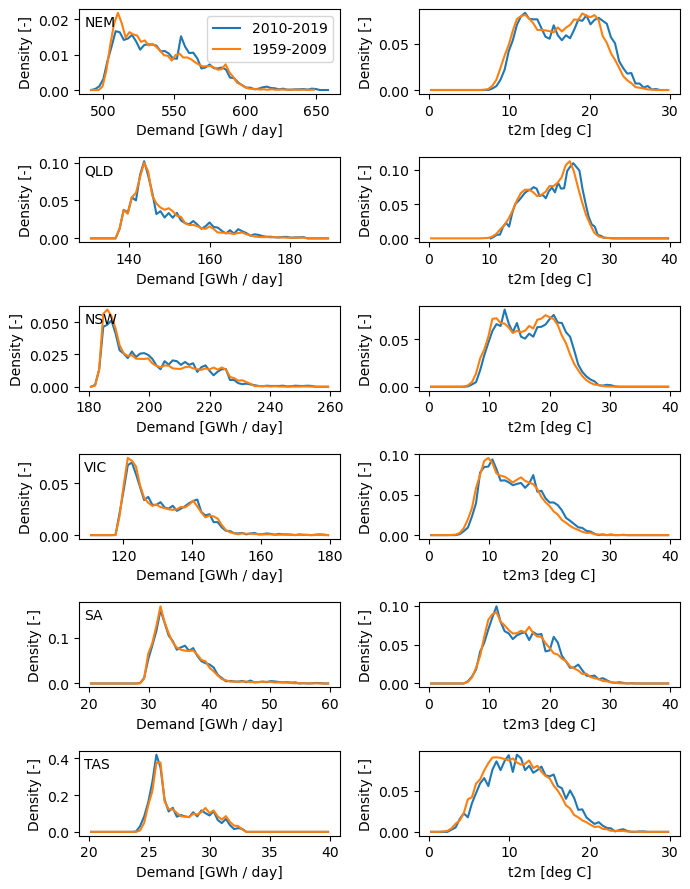

In [27]:
fig, ax = plt.subplots(6, 2, figsize=(7,9))

for i, r in enumerate(regions):
    # Demand histograms
    hists = [
        get_hist(pred_ds[r]["demand"].sel(time=slice("2010", "2019")) / 1000),
        get_hist(pred_ds[r]["demand"].sel(time=slice("1959", "2009")) / 1000)
    ]
    plot_hist(ax[i,0], hists, ["2010-2019", "1959-2009"], "Demand [GWh / day]")     

    ax[i,0].text(0.02, 0.8, r, transform=ax[i,0].transAxes)
    if i == 0:
        ax[i,0].legend()

    # Most important variable histograms
    hists = [
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("2010", "2019")) - 273.15),
        get_hist(pred_ds[r][predictions[r].columns[0]].sel(time=slice("1959", "2009")) - 273.15)
    ]
    plot_hist(ax[i,1], hists, ["2010-2019", "1959-2009"], first_vars[i] + " [deg C]")     

plt.tight_layout()

### Time series of extreme demand days

In [34]:
def normalise(da, period=slice(None, None), dim="time"):
    """
    Normalise by removing mean and dividing by standard deviation
    """
    return (da - da.sel({dim: period}).mean(dim)) / da.sel({dim: period}).std(dim)

In [82]:
def extreme_days(da, q, period=slice(None, None), dim="time"):
    """
    Days above q, where q is computed over period
    """
    thresh = da.sel({dim: period}).quantile(q, dim)
    return da.where(da > thresh)

In [74]:
def plot_2d_series(ax, da, title):
    """
    Plot 2d time series
    """
    da.assign_coords({"region": range(6)}).plot(ax=ax)
    ax.set_yticks(range(6))
    ax.set_yticklabels(regions)
    ax.invert_yaxis()
    ax.set_title(title)

In [28]:
demand = xr.concat(
    [pred_ds[r]["demand"].expand_dims({"region": [r]}) for r in regions],
    "region"
)

In [70]:
baseline = slice("1990", "2019")

In [50]:
q = 1 - 1 / (365 * 1)
print(q)

0.9972602739726028


In [83]:
ext_dpy = extreme_days(demand, q, baseline).resample(time="1YS").count()

In [84]:
ext_dpy.sum("time")

<xarray.DataArray 'demand' (region: 6)>
array([ 46,  43,  54,  50,  49, 100])
Coordinates:
  * region    (region) object 'NEM' 'QLD' 'NSW' 'VIC' 'SA' 'TAS'
    quantile  float64 0.9973

In [72]:
# Normalised annual mean demand
norm_mean = normalise(demand, baseline).resample(time="1YS").mean()

In [73]:
# Normalised annual maximum demand
norm_max = normalise(demand, baseline).resample(time="1YS").max()

In [93]:
# Monthly occurrences of extreme days
monthly_ext = extreme_days(demand, q, baseline).sel(time=baseline).groupby("time.month").count()

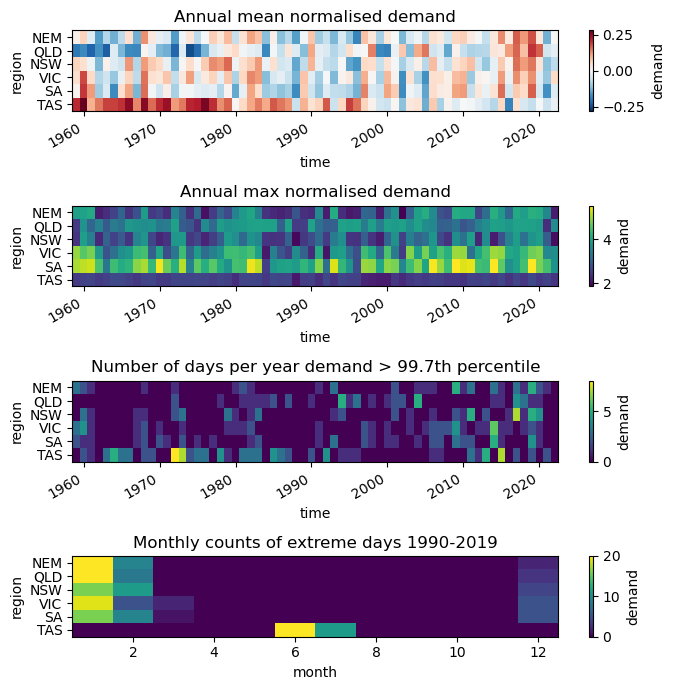

In [94]:
fig, ax = plt.subplots(4, 1, figsize=(7, 7.))

plot_2d_series(ax[0], norm_mean, "Annual mean normalised demand")
plot_2d_series(ax[1], norm_max, "Annual max normalised demand")
plot_2d_series(ax[2], ext_dpy,
               "Number of days per year demand > " + str(np.round(q*100, 1)) + "th percentile"
              )
plot_2d_series(ax[3], monthly_ext, "Monthly counts of extreme days 1990-2019")
plt.tight_layout()

### Synoptic conditions associated with extreme days

Do this only for 1990-2019, as earlier is not representative of today? E.g. TAS

Variables:
- 2m temperature
- 2m relative humidity
- MSLP
- Wind speed and direction
- Cloud cover